<img src="Kinematics.png" width="300">

## Constants

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Arc
from IPython.display import HTML

# -----------------------------
# Link lengths
# -----------------------------
l_1 = 5
l_2 = 5.0
l_3 = 0.5
l_4 = 4.0
l_5 = 1   # perpendicular, ORIGIN at C

# -----------------------------
# Theta1 range (input crank)
# -----------------------------
theta1 = np.linspace(0, 0.45, 400)

# -----------------------------
# Fixed points
# -----------------------------
O = np.array([0.0, 0.0])
C = np.array([0.0, l_4])
E = np.array([C[0] - 1, C[1]])

# -----------------------------
# Spring 
# -----------------------------
L0 = 10    # spring rest length
k  = 100.0   # spring constant


### Computing angles and coordinates of points

In [12]:
# -----------------------------
# Storage for variables
# -----------------------------
A = np.zeros((len(theta1), 2))
B = np.zeros((len(theta1), 2))
D = np.zeros((len(theta1), 2))

# -----------------------------
# Geometry solver
# -----------------------------
for i, t1 in enumerate(theta1):

    A[i] = O + np.array([l_1*np.cos(t1), l_1*np.sin(t1)]) # Point A position

    d = np.linalg.norm(C - A[i]) # Distance AC

    if d > l_2 + l_3 or d < abs(l_2 - l_3): # Checking for triangle inequality, otherwise skip this frame
        B[i] = np.nan
        D[i] = np.nan
        continue

    a = (l_2**2 - l_3**2 + d**2) / (2*d) # Length from A to P along AC, using law of cosines
    h = np.sqrt(l_2**2 - a**2) # Height from P to B, perpendicular to AC
    P = A[i] + a*(C - A[i]) / d # Point P position

    B[i,0] = P[0] + h*(C[1] - A[i,1]) / d # Point Bx position
    B[i,1] = P[1] - h*(C[0] - A[i,0]) / d # Point By position
    #Solving for point D
    v3 = C - B[i] # Vector from B to C
    v3_hat = v3 / np.linalg.norm(v3) # Unit vector along link 3
    n_hat = np.array([v3_hat[1], -v3_hat[0]]) # Perpendicular unit vector to link 3
    D[i] = C + l_5 * n_hat # Vector C to D is always perpendicular to link 3
# -----------------------------
# Remove invalid frames
# -----------------------------
valid = ~np.isnan(B[:,0])
theta1 = theta1[valid]
A = A[valid]
B = B[valid]
D = D[valid]

# -----------------------------
# Spring force magnitude & tension/compression
# -----------------------------
spring_len = np.linalg.norm(D - E, axis=1)  # instantaneous spring length at each frame
spring_extension = L0 - spring_len  # spring compression/extension
Fs = k * spring_extension # spring force magnitude

# -----------------------------
# Storage for angles
# -----------------------------
th1_arr = np.zeros(len(A))
th2_arr = np.zeros(len(A))
th3_arr = np.zeros(len(A))
th4_arr = np.zeros(len(A))
th5_arr = np.zeros(len(A))

# -----------------------------
# Compute angles
# -----------------------------
def angle_deg(p1, p2): # angle from p1 to p2 in degrees
    v = p2 - p1
    return np.degrees(np.arctan2(v[1], v[0]))

def small_angle_deg(th): # wrap angle to [-90, 90] degrees (only used for th4 bc its cw positive)
    th = (th + 180) % 360 - 180
    if th > 90:
        th -= 180
    elif th < -90:
        th += 180
    return th

for i in range(len(A)):
    th1_arr[i] = angle_deg(O, A[i])
    th2_arr[i] = angle_deg(A[i], B[i])
    th3_arr[i] = angle_deg(C, B[i])
    th4_arr[i] = angle_deg(C, D[i])
    th5_arr[i] = angle_deg(E, D[i])


### Computing forces in links

In [13]:
# -----------------------------
# Solution arrays:
n = len(th1_arr)

Ax_arr = np.zeros(n)
Ay_arr = np.zeros(n)
Bx_arr = np.zeros(n)
By_arr = np.zeros(n)
Cx_arr = np.zeros(n)
Cy_arr = np.zeros(n)
Ox_arr = np.zeros(n)
Oy_arr = np.zeros(n)
N_arr  = np.zeros(n)
# ----------------------------- 
# Setting up system of equations

def build_linear_system(th1, th2, th3, th4, th5, Fs):

    M = np.zeros((9, 9))
    b = np.zeros(9)

    # -------------------------------------------------
    # Equation 1
    # -------------------------------------------------
    M[0, :] = [0, 0, -1, 0, 1, 0, 0, 0, 0]
    b[0]    = -Fs*np.cos(np.radians(th5))

    # -------------------------------------------------
    # Equation 2
    # -------------------------------------------------
    M[1, :] = [0, 0, 0, -1, 0, 1, 0, 0, 0]
    b[1]    = -Fs*np.sin(np.radians(th5))

    # -------------------------------------------------
    # Equation 3
    # -------------------------------------------------
    M[2, :] = [0, 0, l_3*np.sin(np.radians(th3)), -l_3*np.cos(np.radians(th3)), 0, 0, 0, 0, 0]
    b[2]    = -l_5*Fs*np.sin(np.radians(th5-th4))

    # -------------------------------------------------
    # Equation 4
    # -------------------------------------------------
    M[3, :] = [-1, 0, 1, 0, 0, 0, 0, 0, 0]
    b[3]    = 0

    # -------------------------------------------------
    # Equation 5
    # -------------------------------------------------
    M[4, :] = [0, -1, 0, 1, 0, 0, 0, 0, 1]
    b[4]    = 0

    # -------------------------------------------------
    # Equation 6
    # -------------------------------------------------
    M[5, :] = [0, 0, -l_2*np.sin(np.radians(th2)), l_2*np.cos(np.radians(th2)), 0, 0, 0, 0, 0]
    b[5]    = 0

    # -------------------------------------------------
    # Equation 7
    # -------------------------------------------------
    M[6, :] = [1, 0, 0, 0, 0, 0, 1, 0, 0]
    b[6]    = 0

    # -------------------------------------------------
    # Equation 8
    # -------------------------------------------------
    M[7, :] = [0, 1, 0, 0, 0, 0, 0, 1, 0]
    b[7]    = 0

    # -------------------------------------------------
    # Equation 9
    # -------------------------------------------------
    M[8, :] = [-l_1*np.sin(np.radians(th1)), l_1*np.cos(np.radians(th1)), 0, 0, 0, 0, 0, 0, 0]
    b[8]    = 0

    return M, b

for i in range(n):

    M, b = build_linear_system(
        th1_arr[i],
        th2_arr[i],
        th3_arr[i],
        th4_arr[i],
        th5_arr[i],
        Fs[i] 
    )

    X = np.linalg.solve(M, b)

    Ax_arr[i], Ay_arr[i], \
    Bx_arr[i], By_arr[i], \
    Cx_arr[i], Cy_arr[i], \
    Ox_arr[i], Oy_arr[i], \
    N_arr[i] = X


## Animation and Plots

C:\Users\zsong\AppData\Local\Temp\ipykernel_23888\1387655393.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[5].legend()


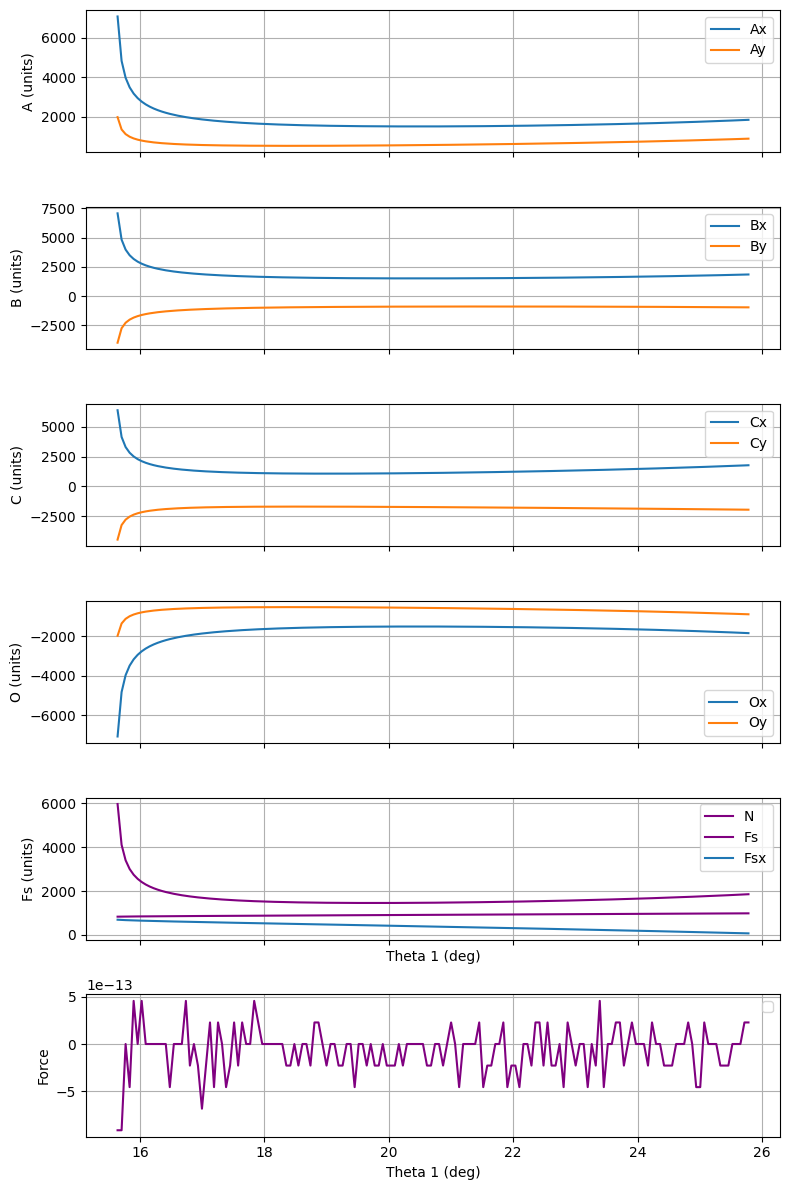

In [14]:
fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)

# Ax & Ay
axs[0].plot(th1_arr, Ax_arr, label='Ax')
axs[0].plot(th1_arr, Ay_arr, label='Ay')
axs[0].set_ylabel('A (units)')
axs[0].legend()
axs[0].grid(True)

# Bx & By
axs[1].plot(th1_arr, Bx_arr, label='Bx')
axs[1].plot(th1_arr, By_arr, label='By')
axs[1].set_ylabel('B (units)')
axs[1].legend()
axs[1].grid(True)

# Cx & Cy
axs[2].plot(th1_arr, Cx_arr, label='Cx')
axs[2].plot(th1_arr, Cy_arr, label='Cy')
axs[2].set_ylabel('C (units)')
axs[2].legend()
axs[2].grid(True)

# Ox & Oy
axs[3].plot(th1_arr, Ox_arr, label='Ox')
axs[3].plot(th1_arr, Oy_arr, label='Oy')
axs[3].set_ylabel('O (units)')
axs[3].legend()
axs[3].grid(True)

# N
axs[4].plot(th1_arr, N_arr, label='N', color='purple')
axs[4].set_xlabel('Theta 1 (deg)')
axs[4].set_ylabel('N (units)')
axs[4].legend()
axs[4].grid(True)

# Fs
axs[4].plot(th1_arr, Fs, label='Fs', color='purple')
axs[4].plot(th1_arr, Fs*np.cos(np.radians(th5_arr)), label='Fsx')
axs[4].set_xlabel('Theta 1 (deg)')
axs[4].set_ylabel('Fs (units)')
axs[4].legend()
axs[4].grid(True)

axs[5].plot(th1_arr, Fs*np.cos(np.radians(th5_arr))+Cx_arr-Bx_arr, color='purple')
axs[5].set_xlabel('Theta 1 (deg)')
axs[5].set_ylabel('Force')
axs[5].legend()
axs[5].grid(True)

plt.tight_layout()
plt.show()


In [15]:
# -----------------------------
# Plot limits
# -----------------------------
all_x = np.hstack([O[0], C[0], E[0], A[:,0], B[:,0], D[:,0]])
all_y = np.hstack([O[1], C[1], E[1], A[:,1], B[:,1], D[:,1]])
pad = 0.5
xmin, xmax = all_x.min()-pad, all_x.max()+pad
ymin, ymax = all_y.min()-pad, all_y.max()+pad

# -----------------------------
# Animation setup
# -----------------------------
fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax+2)
ax.grid(True)

link,  = ax.plot([], [], lw=3)
link5, = ax.plot([], [], lw=3, color='green')
spring, = ax.plot([], [], lw=3, color='purple')
traceB, = ax.plot([], [], lw=1, alpha=0.6)
traceD, = ax.plot([], [], lw=1, linestyle='--')
joints, = ax.plot([], [], 'o')
target, = ax.plot(E[0], E[1], 's', color='purple')

arc1 = Arc(O, 1.0, 1.0, theta1=0, theta2=0, color='black', lw=2)
arc2 = Arc(A[0], 1.0, 1.0, theta1=0, theta2=0, color='black', lw=2)
arc3 = Arc(C, 1.0, 1.0, theta1=0, theta2=0, color='black', lw=2)
arc4 = Arc(C, 1.2, 1.2, theta1=0, theta2=0, color='green', lw=2)
arc5 = Arc(E, 1.0, 1.0, theta1=0, theta2=0, color='purple', lw=2)
for arc in [arc1, arc2, arc3, arc4, arc5]:
    ax.add_patch(arc)

traceBx, traceBy = [], []
traceDx, traceDy = [], []

angle_text = ax.text(0.02, 0.98, "", transform=ax.transAxes,
                     va='top', ha='left', fontsize=10, family="monospace")
# -----------------------------
# Init (clears all data)
# -----------------------------
def init():
    link.set_data([], [])
    link5.set_data([], [])
    spring.set_data([], [])
    traceB.set_data([], [])
    traceD.set_data([], [])
    joints.set_data([], [])
    angle_text.set_text("")
    return link, link5, spring, traceB, traceD, joints, arc1, arc2, arc3, arc4, arc5, angle_text

# -----------------------------
# Update frame by frame
# -----------------------------
def update(i):
    # Main 4-bar
    x = [O[0], A[i,0], B[i,0], C[0], O[0]]
    y = [O[1], A[i,1], B[i,1], C[1], O[1]]
    link.set_data(x, y)

    # Link 5
    link5.set_data([C[0], D[i,0]], [C[1], D[i,1]])

    # Spring
    spring.set_data([D[i,0], E[0]], [D[i,1], E[1]])

    # Traces
    traceBx.append(B[i,0])
    traceBy.append(B[i,1])
    traceB.set_data(traceBx, traceBy)

    traceDx.append(D[i,0])
    traceDy.append(D[i,1])
    traceD.set_data(traceDx, traceDy)

    # Joints
    joint_x = [A[i,0], B[i,0], C[0], D[i,0]]
    joint_y = [A[i,1], B[i,1], C[1], D[i,1]]
    joints.set_data(joint_x, joint_y)

    # Angle arcs
    arc1.center = O
    arc1.theta1 = 0
    arc1.theta2 = th1_arr[i]

    arc2.center = A[i]
    arc2.theta1 = 0
    arc2.theta2 = th2_arr[i]

    arc3.center = C
    arc3.theta1 = 0
    arc3.theta2 = th3_arr[i]

    arc4.center = C
    arc4.theta1 = 0
    arc4.theta2 = th4_arr[i]

    arc5.center = E
    arc5.theta1 = 0
    arc5.theta2 = th5_arr[i]

    # Angle text
    angle_text.set_text(
        f"θ1 (O→A): {th1_arr[i]:7.2f}°\n"
        f"θ2 (A→B): {th2_arr[i]:7.2f}°\n"
        f"θ3 (C→B): {th3_arr[i]:7.2f}°\n"
        f"θ4 (C→D, CW): {th4_arr[i]:7.2f}°\n"
        f"θ5 (E→D): {th5_arr[i]:7.2f}°\n"
        f"Fs: {Fs[i]:7.3f}"
    )
    # Print labels for points
    for txt in ax.texts[1:]: # Remove previous labels except angle_text
        txt.remove()

    offset = 0.15
    ax.text(O[0]-0.1, O[1]-2*offset, 'O', color='black')
    ax.text(A[i,0]+offset, A[i,1], 'A', color='black')
    ax.text(B[i,0]+offset, B[i,1]+offset, 'B', color='black')
    ax.text(C[0]-0.1, C[1]+offset, 'C', color='black')
    ax.text(D[i,0]+offset, D[i,1]+offset, 'D', color='green')
    ax.text(E[0]-0.1, E[1]+offset, 'E', color='purple')

    return link, link5, spring, traceB, traceD, joints, arc1, arc2, arc3, arc4, arc5, angle_text

# -----------------------------
# Create animation
# -----------------------------
ani = FuncAnimation(
    fig,
    update,
    frames=len(A),
    init_func=init,
    interval=30,
    blit=False
)

# -----------------------------
# DISPLAY INLINE
# -----------------------------
HTML(ani.to_jshtml())

#save as gif
#ani.save('four_bar_linkage.gif', writer='pillow', fps=30)
